<a href="https://colab.research.google.com/github/farenga/neuralODEs/blob/main/2_Pendulum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pendulum

In this example we will approximate the dynamics of a damped pendulum via a NeuralODE. The framework is the following, considering $\theta$ as the angular displacement we can write the Newton equation
\begin{equation}
m\mathbf{a} = \mathbf{F}
\end{equation}
we want to introduce a damping factor, inversely proportional to the velocity, so we add it to $\mathbf{F}$ and project the result along the motion direction

\begin{equation}
F = mg\sin\theta - bv = mg\sin\theta - bl\dot{\theta}
\end{equation}

So the pendulum dynamics is described by
\begin{equation}
\ddot{\theta} = \frac{b}{m}\dot{\theta} - g\sin\theta
\end{equation}

In order to describe this dynamics via the neuralODE architecture we will express it as a system of 1st order ODEs, we define $y=\dot{\theta}$, so the equation becomes

\begin{equation}
\begin{bmatrix}
\dot{\theta} \\
\dot{y}
\end{bmatrix} = 
\begin{bmatrix}
y \\
\frac{b}{m}y - \frac{g}{l}\sin\theta\end{bmatrix}
\end{equation}

with the following IVP:

\begin{equation}
\dot{\mathbf{y}} = \mathbf{f}(t,\mathbf{y}(t)) \qquad \mathbf{y}(t_0) = \mathbf{y}_0
\end{equation}

with the vector $\mathbb{y}_0$ components being initial angular displacement and initial angular velocity.

In [94]:
import numpy as np
import math
from scipy.integrate import odeint
import matplotlib.pyplot as plt

In [95]:
 b = .05 # damping
 g = 9.81
 l = 1
 m = 1

In [71]:
# INITIAL CONDITIONS
# angular displacement  theta(0) = 0
# and angular velocity dtheta_dt(0) = 3 rad/s
theta_0 = [0,3]

# TIME SPAN
t = np.linspace(0,10,100)

# DIFFERENTIAL EQ
def system(theta,t,b,g,l,m):
  theta1 = theta[0]
  theta2 = theta[1]
  dtheta1_dt = theta2
  dtheta2_dt = -(b/m)*theta2-(g/l)*math.sin(theta1)
  dtheta_dt = [dtheta1_dt,dtheta2_dt]
  return dtheta_dt

In [72]:
theta = odeint(system, theta_0, t, args=(b,g,l,m))

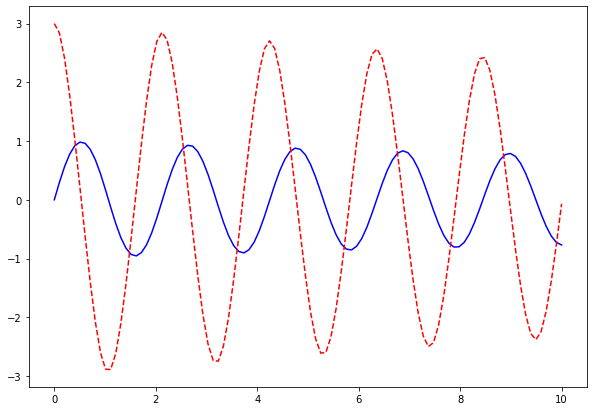

In [73]:
fig = plt.figure(figsize=(10,7))
plt.plot(t,theta[:,0],'b-')
plt.plot(t,theta[:,1],'r--',)

In [74]:
!pip install torchdiffeq

In [75]:
import os
import argparse
import time
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

In [76]:
method = 'dopr15'
data_size = 100
batch_time = 10
batch_size = 20
niters = 500
test_freq = 10
gpu = 0
viz = True
adjoint = True
device = torch.device('cuda:' + str(gpu) if torch.cuda.is_available() else 'cpu')

In [77]:
if adjoint:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint

In [78]:
true_y0 = torch.tensor([[0., 3.]]).to(device)
t = torch.linspace(0., 10., data_size).to(device)

In [79]:
class Lambda(nn.Module):

    def forward(self, t, y):
      theta1 = y[0][0]
      theta2 = y[0][1]
      dtheta1_dt = theta2
      dtheta2_dt = -(b/m)*theta2-g*math.sin(theta1)
      dtheta_dt = [dtheta1_dt,dtheta2_dt]
      return torch.tensor([ [ dtheta1_dt ],[ dtheta2_dt ] ]).reshape([1,2]).to(device)

In [80]:
with torch.no_grad():
    true_y = odeint(Lambda(), true_y0, t, method='dopri5')

In [88]:
def get_batch():
    # s: array of random indices used to extract batches
    s = torch.from_numpy(np.random.choice(np.arange(data_size - batch_time, dtype=np.int64), batch_size, replace=False))
    # added noise to train data
    noisy_batch_y0 = true_y[s]  # shape: (batch_size, 1, 2)
    noisy_batch_y0[:,:,1] = noisy_batch_y0[:,:,1]+torch.normal(0,.01,size=noisy_batch_y0[:,:,1].shape).to(device)
    batch_t = t[:batch_time]  #  shape: (10)
    batch_y = torch.stack([true_y[s + i] for i in range(batch_time)], dim=0)  # shape: (10,batch_size,1,2)
    return noisy_batch_y0.to(device), batch_t.to(device), batch_y.to(device)

In [82]:
def makedirs(dirname):
    if not os.path.exists(dirname):
        os.makedirs(dirname)

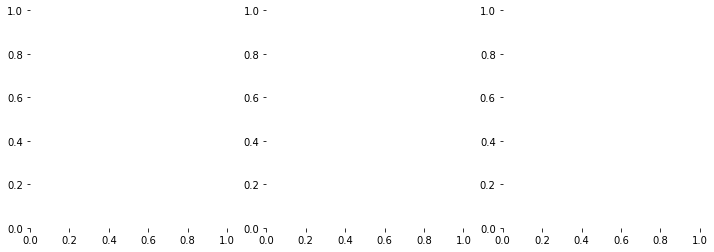

In [83]:
if viz:
    makedirs('png')
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(12, 4), facecolor='white')
    ax_traj = fig.add_subplot(131, frameon=False)
    ax_phase = fig.add_subplot(132, frameon=False)
    ax_vecfield = fig.add_subplot(133, frameon=False)
    plt.show(block=False)

In [92]:
plot_x_sup_lim = 1.2
plot_x_inf_lim = -1.2
plot_y_sup_lim = 3.2
plot_y_inf_lim = -3.2

def visualize(true_y, pred_y, odefunc, itr, batch_y, batch_t):

    if viz:

        ax_traj.cla()
        ax_traj.set_title('Trajectories')
        ax_traj.set_xlabel('t')
        ax_traj.set_ylabel('x,y')
        ax_traj.plot(t.cpu().numpy(), true_y.cpu().numpy()[:, 0, 0], t.cpu().numpy(), true_y.cpu().numpy()[:, 0, 1], 'g-')
        ax_traj.plot(t.cpu().numpy(), pred_y.cpu().numpy()[:, 0, 0], '--', t.cpu().numpy(), pred_y.cpu().numpy()[:, 0, 1], 'b--')
        ax_traj.set_xlim(t.cpu().min(), t.cpu().max())
        ax_traj.set_ylim(plot_y_inf_lim, plot_y_sup_lim)
        #ax_traj.legend()

        ax_phase.cla()
        ax_phase.set_title('Phase Portrait')
        ax_phase.set_xlabel('x')
        ax_phase.set_ylabel('y')
        ax_phase.plot(true_y.cpu().numpy()[:, 0, 0], true_y.cpu().numpy()[:, 0, 1], 'g-')
        ax_phase.plot(pred_y.cpu().numpy()[:, 0, 0], pred_y.cpu().numpy()[:, 0, 1], 'b--')
        ax_phase.plot(batch_y0.cpu().numpy()[:, 0, 0], batch_y0.cpu().numpy()[:, 0, 1], 'r*')
        ax_phase.set_xlim(plot_x_inf_lim, plot_x_sup_lim)
        ax_phase.set_ylim(plot_y_inf_lim, plot_y_sup_lim)

        ax_vecfield.cla()
        ax_vecfield.set_title('Learned Vector Field')
        ax_vecfield.set_xlabel('x')
        ax_vecfield.set_ylabel('y')

        y,x = np.mgrid[plot_y_inf_lim:plot_y_sup_lim:21j, plot_x_inf_lim:plot_x_sup_lim:21j]
        dydt = odefunc(0, torch.Tensor(np.stack([x, y], -1).reshape(21 * 21, 2)).to(device)).cpu().detach().numpy()
        mag = np.sqrt(dydt[:, 0]**2 + dydt[:, 1]**2).reshape(-1, 1)
        dydt = (dydt / mag)
        dydt = dydt.reshape(21, 21, 2)

        ax_vecfield.streamplot(x, y, dydt[:, :, 0], dydt[:, :, 1], color="black")
        ax_vecfield.set_xlim(plot_x_inf_lim,plot_x_sup_lim)
        ax_vecfield.set_ylim(plot_y_inf_lim,plot_y_sup_lim)

        fig.tight_layout()
        fig.savefig('png/{:03d}'.format(itr))
        fig.show()
        #plt.draw()
        #plt.pause(0.001)

In [85]:
class ODEFunc(nn.Module):
    counter = 0
    def __init__(self):
        super(ODEFunc, self).__init__()
        self.counter += 1
        #print('in ODEFunc(nn.Module)')
        self.net = nn.Sequential(
            nn.Linear(2, 50),
            nn.ReLU(),
            nn.Linear(50, 2)
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        #print('in forward(self,t,y) of ODEFunct')
        return self.net(y)

In [86]:
class RunningAverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, momentum=0.99):
        self.momentum = momentum
        self.reset()

    def reset(self):
        self.val = None
        self.avg = 0

    def update(self, val):
        if self.val is None:
            self.avg = val
        else:
            self.avg = self.avg * self.momentum + val * (1 - self.momentum)
        self.val = val

In [93]:
ii = 0

func = ODEFunc().to(device)
#optimizer = optim.RMSprop(func.parameters(), lr=1e-3)
end = time.time()

time_meter = RunningAverageMeter(0.97)
loss_meter = RunningAverageMeter(0.97)
learnrate = 1e-3
loss_array = []
for itr in range(1, niters + 1):
    optim.RMSprop(func.parameters(), lr=learnrate).zero_grad()
    batch_y0, batch_t, batch_y = get_batch()
    pred_y = odeint(func, batch_y0, batch_t).to(device)
    loss = torch.mean(torch.abs(pred_y - batch_y))
    learnrate = 1e-5 if loss.item()<.1 else 1e-3
    loss.backward()
    optim.RMSprop(func.parameters(), lr=learnrate).step()

    time_meter.update(time.time() - end)
    loss_meter.update(loss.item())
    if itr % test_freq == 0:
        with torch.no_grad():
            pred_y = odeint(func, true_y0, t)
            loss = torch.mean(torch.abs(pred_y - true_y))
            loss_array.append(loss.item())
            print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
            visualize(true_y, pred_y, func, ii, batch_y0, batch_t)
            ii += 1
    end = time.time()

Iter 0010 | Total Loss 1.180024
Iter 0020 | Total Loss 1.067099
Iter 0030 | Total Loss 1.005938
Iter 0040 | Total Loss 0.826055
Iter 0050 | Total Loss 1.379892
Iter 0060 | Total Loss 0.470264
Iter 0070 | Total Loss 0.490069
Iter 0080 | Total Loss 0.523011
Iter 0090 | Total Loss 0.571996
Iter 0100 | Total Loss 0.661030
Iter 0110 | Total Loss 0.727931
Iter 0120 | Total Loss 0.734791
Iter 0130 | Total Loss 0.698316
Iter 0140 | Total Loss 0.626427
Iter 0150 | Total Loss 0.619972
Iter 0160 | Total Loss 0.613513
Iter 0170 | Total Loss 0.583946
Iter 0180 | Total Loss 0.591135
Iter 0190 | Total Loss 0.521747
Iter 0200 | Total Loss 0.500904
Iter 0210 | Total Loss 0.500596
Iter 0220 | Total Loss 0.478716
Iter 0230 | Total Loss 0.412460
Iter 0240 | Total Loss 0.381444
Iter 0250 | Total Loss 0.369231
Iter 0260 | Total Loss 0.379823
Iter 0270 | Total Loss 0.405196
Iter 0280 | Total Loss 0.364495
Iter 0290 | Total Loss 0.360775
Iter 0300 | Total Loss 0.340089
Iter 0310 | Total Loss 0.377738
Iter 032

Text(0, 0.5, 'loss')

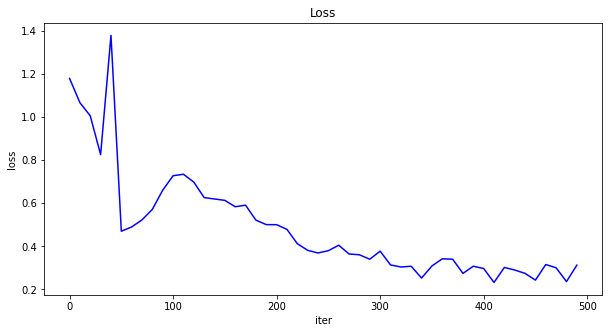

In [96]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(0,len(loss_array))*test_freq,loss_array,'-b')
plt.title('Loss')
plt.xlabel('iter')
plt.ylabel('loss')

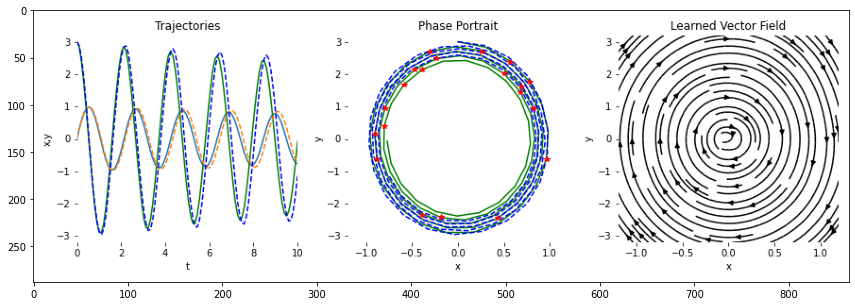

In [97]:
plt.figure(figsize=(15,5))
plt.imshow(plt.imread('/content/png/049.png'))

In [98]:
!ls png/
!zip -r /content/png.zip /content/png

000.png  006.png  012.png  018.png  024.png  030.png  036.png  042.png	048.png
001.png  007.png  013.png  019.png  025.png  031.png  037.png  043.png	049.png
002.png  008.png  014.png  020.png  026.png  032.png  038.png  044.png
003.png  009.png  015.png  021.png  027.png  033.png  039.png  045.png
004.png  010.png  016.png  022.png  028.png  034.png  040.png  046.png
005.png  011.png  017.png  023.png  029.png  035.png  041.png  047.png
  adding: content/png/ (stored 0%)
  adding: content/png/033.png (deflated 2%)
  adding: content/png/022.png (deflated 2%)
  adding: content/png/013.png (deflated 2%)
  adding: content/png/014.png (deflated 2%)
  adding: content/png/008.png (deflated 2%)
  adding: content/png/027.png (deflated 2%)
  adding: content/png/021.png (deflated 2%)
  adding: content/png/001.png (deflated 4%)
  adding: content/png/007.png (deflated 2%)
  adding: content/png/002.png (deflated 4%)
  adding: content/png/030.png (deflated 2%)
  adding: content/png/020.png (deflated

In [ ]:
#from google.colab import files
#files.download("/content/png.zip")

In [ ]:
#!rm -r png
#!rm -r png.zip

# Learned Dynamics

In [118]:
t = 10
y = torch.Tensor([.5,.2]).to(device)

dydt_pred = func(t,y).cpu().detach().numpy()

In [119]:
dydt_pred

array([ 0.23741476, -5.0550027 ], dtype=float32)

In [142]:
from torchdiffeq import odeint

y0 = torch.tensor([[.5, .5]]).to(device)
t = torch.linspace(0., 10., 5).to(device)
y_pred = odeint(func, y0, t).to(device)

In [143]:
y_pred

tensor([[[ 0.5000,  0.5000]],

        [[-0.1115, -1.3767]],

        [[-0.2796,  0.9644]],

        [[ 0.3864, -0.0808]],

        [[-0.2579, -0.6565]]], device='cuda:0', grad_fn=<CopySlices>)

In [138]:
torch.save(func.state_dict(), 'pendulum')